# Sistema de recomendacion 
* Esta caso usamos el dataset de MovieLens 
* Cargamos el Dataset y luego hacemos un dato exploratorio
* creamos un modelo predictivo segun la calificacion de cada usuario a cada que pelicula
    * buscar los usuarios mas similares posibles para recomendar X pelicula segun sus gustos
    
    
* **El modelo predictivo cuenta con un error solamente de un 7.72% en el entrenamiento y 7.52% en el test.**


* Este es un sistema o predictor basado en recomendaciones por similaridades entre los usuarios(que contienen una valoracion similar o uniforme por parte de los usuarios) y a partir de eso hemos establecido un sistema de recomendaciones basandonos en ponderar todas y cada una de las distancias establecidas por los valores que dieron dichos usuarios a las peliculas.

In [154]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [155]:
df = pd.read_csv("/Users/Acer/Desktop/Cursos-Udemy-Machine-Learning/python-ml-course-master/datasets/ml-100k/u.data" , sep="\t", header=None)
type(df)

pandas.core.frame.DataFrame

In [156]:
df.shape

(100000, 4)

In [157]:
df.columns = ["UserID" , "ItemID" , "Raiting" , " TimeStamp" ]
df.head()

,UserID,ItemID,Raiting,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


* Ahora haremos un analisis exploratorio de los datos, antes de iniciar nuestros datos de recomendacion

----
---


## Analisis exploratorioa de los items

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

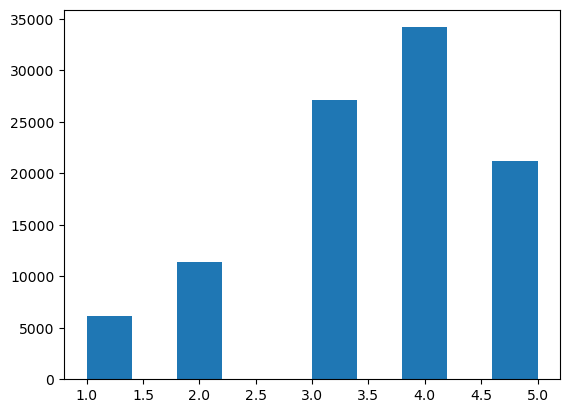

In [158]:
plt.hist(df["Raiting"])

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <BarContainer object of 10 artists>)

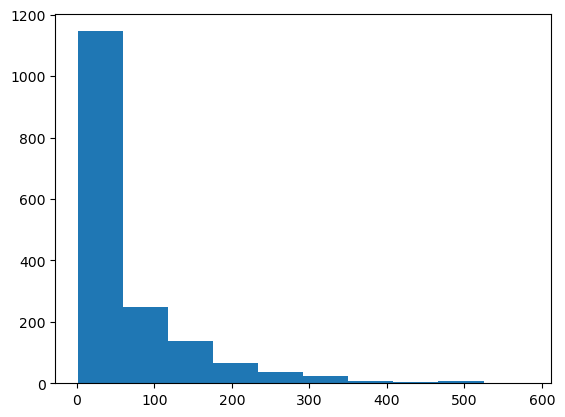

In [159]:
#Hacemos otro groupby de cuantas personas vieron cada pelicula (de la 1 la 50 la vieron 452 y asi...)
plt.hist(df.groupby(["ItemID"])["ItemID"].count())

Como podemos ver el conjunto de peliculas de la 1 a la 50 tiene mas vistas que las demas (es decir las primeras 50 peliculas fueron vistas mas veces)

* obviamente las peliculas mas vistas van a entrar mas facilmente en recomendaciones. Si una peli no fue muy vista o no es ni valorada por la poca gente que la vio es muy dificil que sea recomendada.


* Estos nos va a llevar a pensar que a veces en lugar de basarnos 100% en lo que nos diga el algoritmo de recomendación. es que de vez en cuando tendríamos que incluir películas de éstas que son poco vistas para evitar caer en la monotonia de solamente las 50 pelis mas vistas


* Por eso mismo las pelis menos vistas necesitan de vez en cuando ser recomendadas y por eso nuestro sistema tendrá que tenerlas en cuenta, en algún caso si queremos que éstas tengan las mismas opciones "por así decir" que los "grandes pelis o Titanes" de la industria del cine, en este caso.

-----
----

## Representacion en froma matricial ( matriz de representacion)


*  para ofrecer un sistema de recomendaciones necesitamos tener una matriz de valoraciones


* Cada fila contenga por ejemplo un usuario y cada una de las columnas sea una película de modo que la combinación fila y columna me dé la valoración que un usuario le ha dado a una película. por ejemplo va a pasar que "X" usuario no vio tal peliculas y le pondremos un 0.

**Filas = Usuarios , Columnas = N° de peliculas**

In [160]:
         #Sabes solamente de los usuarios
n_users = df.UserID.unique().shape[0]
n_users

943

In [161]:
    #Numeros de peliculas
n_items = df.ItemID.unique().shape[0]
n_items

1682

In [162]:
#Creamos la matriz de valoraciones, (en este caso matriz de CEROS)
ratings = np.zeros((n_users , n_items)) #agregue 0 tanto en la fila de usuarios y en las columnas de pelis

for row in df.itertuples():
    ratings[row[1]-1 , row[2]-1] = row[3]

In [163]:
ratings.shape

(943, 1682)

In [164]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [165]:
#Ahora veremos que porcentaje de la matriz no contiene 0
sparsity = float(len(ratings.nonzero()[0]))
sparsity /=(ratings.shape[0]*ratings.shape[1]) #dividimo la SPARSITY / N° de filas * N° de columnas 
sparsity *=100
print("coeficiente de sparseidad:{:4.2f}%".format(sparsity))

coeficiente de sparseidad:6.30%


Es decir que el 6.30% de esa matriz no esta vacia y contiene datos (los 0 son datos NaN).

* Por eso mismo tenemos margen más que de sobras para ofrecer recomendaciones de pelis que los usuarios no hayan visto.

---


## Crear conjunto de entrenamiento y validacion

* buscar usuarios que se parezcan entre si y ponderar sus decisiones, sus valoraciones, sus películas que les gustan para ofrecérselas al usuario con el que estamos testeando.

In [166]:
from sklearn.model_selection import cross_validate , train_test_split
from sklearn import metrics

In [167]:
ratings_train , ratings_test = train_test_split(ratings, test_size = 0.3 , random_state=42) 
ratings_train.shape

(660, 1682)

In [168]:
ratings_test.shape

(283, 1682)

en ratings_test usaremos 283 usuarios para ofrecerles una recomendacion

In [169]:
sim_matrix_test = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_test)

sim_matrix_train = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)

In [170]:
sim_matrix_train

array([[1.        , 0.17448349, 0.18009754, ..., 0.13331459, 0.17695593,
        0.21882481],
       [0.17448349, 1.        , 0.07993097, ..., 0.07175808, 0.09552622,
        0.05512655],
       [0.18009754, 0.07993097, 1.        , ..., 0.0191736 , 0.02233385,
        0.10310785],
       ...,
       [0.13331459, 0.07175808, 0.0191736 , ..., 1.        , 0.04853428,
        0.05142508],
       [0.17695593, 0.09552622, 0.02233385, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.21882481, 0.05512655, 0.10310785, ..., 0.05142508, 0.1198022 ,
        1.        ]])

Como podemos ver en diagonal tiene siempre resultado 1 por que obviamente es similar a si mismo un usuario, y ahi vemos el porcentaje por asi decirlo de cuanto hay de compatibilidad entre usuarios

* como podemos ver el usuario 1 con el 2 esta a distancia 0.17 - el 1 con el 3 a 0.18 y asi sucesivamente


* tambien podemos observar que la matriz es SIMETRICA es decir que el valor del usuario 1 al 2 es la misma que del 2 al 1. o del 1 al 3 y del 3 al 1. con eso tenemos el doble de informacion, pero no hay problema por que es un paso previo a poder hacer la predicción del usuario

In [171]:
users_predictions_test = sim_matrix_test.dot(ratings_test) / np.array([np.abs(sim_matrix_test).sum(axis=1)]).T

users_predictions_train = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T

In [172]:
from sklearn.metrics import mean_squared_error

def get_mse(preds, actuals):
    if preds.shape[0] != actuals.shape[0]: #Si las predicciones en la 0 no coinciden con las actuales TRANSPONEMOS
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [173]:
get_mse(users_predictions_test, ratings_test)

7.51355110112698

In [174]:
get_mse(users_predictions_train, ratings_train)

7.878218313143215

* Segun el error que tenemos es un algoritmo muy bueno con muy poco margen de error tanto como en el entrenamiento y en el testeo

---


# Filtro colaborativo basado en los KNN (los "K" vecinos)

* Ahora vamos a refinar el algoritmo juntando esta idea de filtro colaborativo basado en usuarios con la idea de los KNN (los ka vecinos) - para que tome los mas parecidos

In [175]:
from sklearn.neighbors import NearestNeighbors

In [176]:
k = 3

neighbors = NearestNeighbors(n_neighbors=k , metric="cosine")

neighbors.fit(ratings_train)

NearestNeighbors(metric='cosine', n_neighbors=3)

In [177]:
#Buscamos el top de distancia de similaridades y de usuarios 
top_k_distances , top_k_users = neighbors.kneighbors(ratings_train , return_distance=True)
top_k_distances.shape

(660, 3)

In [178]:
top_k_distances[0]

array([0.        , 0.49780748, 0.55784838])

In [179]:
top_k_users[0] 

array([  0, 211,  16], dtype=int64)

* nos a devuelto el top ten de distancias entre cada usuario y su top ten respectivo,

In [180]:
        #Prediccion de los "K" usuarios
users_predicts_k = np.zeros(ratings_train.shape)
for i in range ( ratings_train.shape[0]): #para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) /np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [181]:
users_predicts_k.shape #Para cada usuarios 1682 peliculas como prediccion

(660, 1682)

In [182]:
users_predicts_k

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [4.49730595, 3.49730595, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.44978452, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [183]:
get_mse(users_predicts_k , ratings_train)

4.91474054313352

* Este es el error del modelo creado recientemente (4.91%) se puede ver que bajo un poco mas el error (va mejorando el modelo)

In [184]:
top_k_distances_test,top_k_users_test = neighbors.kneighbors(ratings_test,return_distance=True)

In [185]:
top_k_users_test[0]

array([317, 336,  26], dtype=int64)

In [186]:
user_predicts_k_test= np.zeros(ratings_test.shape)
for i in range(ratings_test.shape[0]):# para cada usuario del conjunto de entrenamiento
    user_predicts_k_test[i,:] = top_k_distances_test[i].T.dot(ratings[top_k_users_test][i])/ np.array([np.abs(top_k_distances_test[i].T).sum(axis=0)]).T

In [187]:
get_mse(user_predicts_k_test,ratings_test)

10.148160336467035

* Aca vemos que aumento considerablement el error con el conjunto de testing a un 10.14%

---

# Filtro colaborativo basado en items

In [188]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [189]:
neighbors = NearestNeighbors(n_neighbors=1682 ,radius="cosine")

In [190]:
neighbors.fit(ratings_train.T)

NearestNeighbors(n_neighbors=1682, radius='cosine')

In [191]:
#ahora calcularemos la matriz de similaridades basandonos en el coseno y los KNN, como hicimos anteriormente 
top_k_distances , top_k_items = neighbors.kneighbors(ratings_train.T,return_distance=True) 

In [192]:
top_k_distances.shape

(1682, 1682)

In [193]:
top_k_items

array([[   0,  120,  404, ...,  285,  312,  301],
       [   1,  575,  232, ...,  257,   99,   49],
       [   2,  742, 1094, ...,  180,   99,   49],
       ...,
       [1679, 1581, 1579, ...,  180,   99,   49],
       [1680, 1671, 1679, ...,  180,   99,   49],
       [1681, 1596, 1679, ...,  180,   99,   49]], dtype=int64)

In [194]:
#ahora predeciremos la valoracion de las peliculas, como hicimos anteriormente
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [195]:
item_preds.shape

(660, 1682)

In [196]:
item_preds

array([[0.        , 0.31842643, 0.37009323, ..., 1.44850442, 1.4566397 ,
        1.54530823],
       [0.        , 0.0545379 , 0.06227954, ..., 0.20078701, 0.20112087,
        0.21332472],
       [0.        , 0.03522479, 0.04073126, ..., 0.18456903, 0.18654661,
        0.20076303],
       ...,
       [0.        , 0.08968346, 0.10313623, ..., 0.42050197, 0.4196067 ,
        0.45863507],
       [0.        , 0.25835756, 0.29918119, ..., 1.31043371, 1.32278067,
        1.41390683],
       [0.        , 0.07174777, 0.08538024, ..., 0.25535196, 0.25259645,
        0.26199652]])

In [197]:
get_mse(item_preds, ratings_train)

11.172565375125632

In [210]:
movies_df = pd.read_csv("/Users/Acer/Desktop/Cursos-Udemy-Machine-Learning/python-ml-course-master/datasets/ml-100k/u.item.csv" , sep="|", header=None, encoding='latin-1')
movies_df.head(121)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,117,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
117,118,Twister (1996),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Twister%20(1996),0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
118,119,Maya Lin: A Strong Clear Vision (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Maya%20Lin:%2...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119,120,Striptease (1996),28-Jun-1996,NaN,http://us.imdb.com/M/title-exact?Striptease%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [209]:
top_k_items

array([[   0,  120,  404, ...,  285,  312,  301],
       [   1,  575,  232, ...,  257,   99,   49],
       [   2,  742, 1094, ...,  180,   99,   49],
       ...,
       [1679, 1581, 1579, ...,  180,   99,   49],
       [1680, 1671, 1679, ...,  180,   99,   49],
       [1681, 1596, 1679, ...,  180,   99,   49]], dtype=int64)

* Como podemos ver vemos que la pelicula **0(toy story)** fue comparada con la **120(Dia de la independencia) y 404(Mision imposible)**
    * podemos ver que la trama u genero de dichas peliculas no tienen mucho de igual,pero si por ejemplo son de la misma fechas, lo que podemos decir es que los usuarios son coetaneo u nacidos en años similares, por eso eligen pelis del mismo año
    * lo que podemos tmb ver en otro vistazo rapido es que la pelicula **99(fargo) y 49(star wars) no la recomiendan mucho
    
    
* **Esto es un sistema o predictor basado en recomendaciones por similaridades entre los usuarios(que contienen una valoracion similar o uniforme por parte de los usuarios) y a partir de eso hemos establecido un sistema de recomendaciones basandonos en ponderar todas y cada una de las distancias establecidas por los valores que dieron dichos usuarios a las peliculas.**

In [218]:

neighbors = NearestNeighbors(n_neighbors=10 , radius="cosine")

neighbors.fit(ratings_train.T)

top_k_distances , top_k_items = neighbors.kneighbors(ratings_train.T , return_distance=True) 

top_k_distances[0]

array([ 0.        , 53.12249994, 54.38749856, 55.50675635, 56.49778757,
       56.9473441 , 57.21013896, 57.81003373, 58.10335619, 58.16356248])

vemos que la distancia es entre 53.12  y 68.16

In [220]:
top_k_items[0] 

array([  0, 120, 404, 116, 221, 150, 117, 180,   6, 741], dtype=int64)

* estas son las 10 peliculas mas parecida a la **0 (toy story)** en forma decreciente

In [221]:
#Una prediccion basandonos en este top_k de similaridades

preds = np.zeros(ratings_train.T.shape) #Creamos una matriz llenas ceros

for i in range (ratings_train.T.shape[0]):
    if(i%50==0):
        print("iter"+str(i)) #Aqui ponemos que cada 50 itaraciones nos iprima
    den = 1 
    preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i])/np.array([np.abs(top_k_distances[i]).sum(axis=0)]).T

iter0
iter50
iter100
iter150
iter200
iter250
iter300
iter350
iter400
iter450
iter500
iter550
iter600
iter650
iter700
iter750
iter800
iter850
iter900
iter950
iter1000
iter1050
iter1100


C:\Users\Acer\AppData\Local\Temp\ipykernel_15556\1182874128.py:7: RuntimeWarning: invalid value encountered in true_divide
  preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i])/np.array([np.abs(top_k_distances[i]).sum(axis=0)]).T


iter1150
iter1200
iter1250
iter1300
iter1350
iter1400
iter1450
iter1500
iter1550
iter1600
iter1650


In [268]:


from sklearn.metrics import mean_squared_error

def get_mse(preds, actuals):
    if preds.shape[0] != actuals.shape[0]: #Si las predicciones en la 0 no coinciden con las actuales TRANSPONEMOS
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [270]:
preds = np.isfinite(preds)
preds

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [264]:
print(ratings_train.shape, ratings_test.shape, preds.shape)

(660, 1682) (283, 1682) (1682, 660)


In [265]:
get_mse(preds,ratings_train.T)

7.72753714555901

* Podemos ver que el error de este modelo predictivo con los datos de entrenamiento es de 7.72 %

In [266]:
get_mse(preds, ratings_test.T)

7.528188830403549

* el error con los datos de testeo es de 7.52% casi el mismo error 